<a href="https://colab.research.google.com/github/mlfigueiredo/CienciaDosDados/blob/main/PLN_An%C3%A1lise_de_Satisfa%C3%A7%C3%A3o_dos_Clientes_do_E_commerce_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='GREY'> PLN - Análise de Satisfação dos Clientes do E-commerce</font>


**Olist**: “A plataforma olist está presente nos principais canais online do Brasil. É a maior loja de departamentos no mercado brasileiro. 
 www.olist.com


![alt text](https://i.imgur.com/JuJMns1.png)
![alt text](https://olist.com/wp-content/uploads/2020/02/lojas-de-celulares-e-smartphones-790x1024.jpg)

#1° - Problema de Negócio - Entendendo seus clientes



1. Precisamos compreender as avaliações dos clientes pois elas são cruciais para o sucesso de uma empresa.

2. Precisamos avaliar o sentimento do cliente em relação à marca. 

A análise dos comentários ajuda a discernir adequadamente as diferentes preferências, gostos, desgostos, etc. do cliente. Esses insights extraídos podem ser usados ​​para melhorar o serviço e a experiência do cliente. 


# 2° - Análise Exploratória dos Dados 



## **Fonte de Dados**: 

 Este é um conjunto de dados público de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em diversos mercados no Brasil. 

Seus recursos permitem a visualização de um pedido em múltiplas dimensões: desde o status do pedido, preço, desempenho de pagamento e frete até a localização do cliente, atributos do produto e, **finalmente, avaliações escritas pelos clientes**. Também lançamos um conjunto de dados de geolocalização que relaciona os códigos postais brasileiros às coordenadas lat / lng.


Estes **são dados comerciais reais**, foram anonimizados e as referências às empresas e parceiros no texto da avaliação foram substituídas pelos nomes das grandes casas de Game of Thrones.

 
 https://www.kaggle.com/olistbr/brazilian-ecommerce

In [35]:
# Importing needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Pacotes de PLN para trabalhar com texto
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK tools for text processing
import re, nltk # para extrair informações de páginas web e expressões regulares
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [36]:

# Reading in the reviews dataset
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.head()
review_df.shape

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


(100000, 7)

In [37]:
# We have missing values in the reviews and their titles
review_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#3° Pré-Processamento


Em seguida, leríamos nossos dados e realizaríamos algumas modificações iniciais no EDA e no conjunto de dados. O conjunto de dados de revisão tem uma quantidade significativa de valores NaN no texto e no título das revisões, portanto, teríamos certeza de eliminar esses valores ausentes e redefinir o índice.

Assim como as tarefas normais do dia-a-dia da PNL, precisamos implementar algumas etapas de pré-processamento necessárias que envolvem; transformar os dados das revisões removendo stopwords, usando o módulo de expressão regular para aceitar apenas letras, tokenizando o texto e tornando todas as palavras em minúsculas para consistência, eliminar números, acentos, caracteres especiais. Nesse caso, teríamos que remover palavras irrelevantes em português.

In [38]:
#Separando em dois campos de estudo: Vamos estudar separadamente o título e a Descrição da avaliação
review_data_title = review_df['review_comment_title']
review_data = review_df.drop(['review_comment_title'],axis=1)

In [46]:
df_title.head(16)

0                   recomendo
1             Super recomendo
2     Não chegou meu produto 
3                       Ótimo
4                  Muito bom.
5                         Bom
6                Maravilhoso!
7            Entrega perfeita
8                       Ótimo
9                    MT lindo
10            Ótimo Produto! 
11         RECOMENDO SEMPRE!!
12            ***** Recomendo
13      Não recebi o produto.
14                      OTIMO
15            Entrega atrasou
Name: review_comment_title, dtype: object

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34


(100000, 6)

In [40]:
# Dropping NaN values
review_data  = review_data.dropna()
review_data_title = review_data_title.dropna()

In [41]:
review_data_title

9                        recomendo
15                 Super recomendo
19         Não chegou meu produto 
22                           Ótimo
34                      Muito bom.
                   ...            
99967                            👍
99971           muito bom produto 
99972    Não foi entregue o pedido
99974              OTIMA EMBALAGEM
99975               Foto enganosa 
Name: review_comment_title, Length: 11715, dtype: object

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...
99983,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99990,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [42]:
# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


(41753, 6)

In [43]:
# Resetting the reviews titles index and visualizing the data
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(10)
review_data_title.shape

0                  recomendo
1            Super recomendo
2    Não chegou meu produto 
3                      Ótimo
4                 Muito bom.
5                        Bom
6               Maravilhoso!
7           Entrega perfeita
8                      Ótimo
9                   MT lindo
Name: review_comment_title, dtype: object

(11715,)

A partir das células de código acima, podemos deduzir que **58% dos clientes não deixaram comentários e apenas 11,7% dos clientes se preocuparam em dar títulos aos seus comentários.**
Em seguida, iríamos pré-processar as revisões e os títulos em preparação para visualização e modelagem

In [44]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)#somente letras, transforma o que não é letra em vazio
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences em parágrafos, frase e palavra
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

In [47]:
comments

['recebi bem antes prazo estipulado',
 'parab ns lojas lannister adorei comprar internet seguro pr tico parab ns todos feliz p scoa',
 'aparelho eficiente site marca aparelho impresso desinfector chegar outro nome atualizar marca correta vez aparelho',
 'pouco travando valor ta boa',
 'vendedor confi vel produto ok entrega antes prazo',
 'gostaria saber sempre recebi compra agora decpcionou',
 'p ssimo',
 'loja nota',
 'obrigado aten amim dispensada',
 'compra realizada facilmente entrega efetuada antes prazo dado produto j come usado at presente problemas',
 'rel gio bonito barato',
 'n gostei comprei gato lebre',
 'sempre compro internet entrega ocorre antes prazo combinado acredito prazo m ximo stark prazo m ximo j esgotou ainda n recebi produto',
 'recebi exatamente esperava demais encomendas outros vendedores atrasaram chegou prazo',
 'recomendo',
 'boa',
 't completamente apaixonada loja super respons vel confi vel',
 'nada chegar pedido',
 'bom cheiroso',
 'otimo vendedor chegou

Visualização de dados
Após o pré-processamento de nossos dados, é hora de visualizar nosso texto de revisão usando Wordclouds. Um Wordcloud é uma representação visual dos dados do texto envolvidos e mostra a importância das palavras pelo tamanho da fonte.

<Figure size 1440x864 with 0 Axes>

(-0.5, 1499.5, 999.5, -0.5)

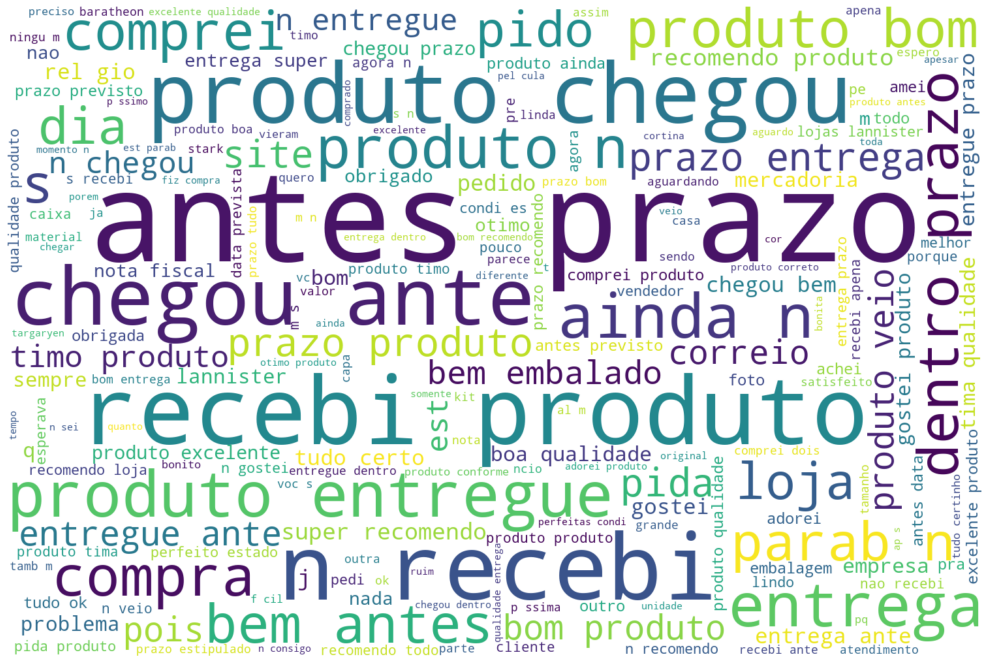

In [53]:
# Visualizing the cleaned reviews data(uncomment to see)
# comments
#Using wordcloud to visualize the comments
unique_string=(" ").join(comments)
wordcloud = WordCloud(width = 1500, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [54]:
# Using CountVectorizer to get the most important unigrams (1 palavra)
co = CountVectorizer(ngram_range=(1,1)) #calculo para quebra palavra por palavra. para dar peso as palavras mais importantes
counts = co.fit_transform(comments) 
#imprimir as mais importantes em ordem de mais importantes
important_unigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
# as palavravras mais importantes
important_unigrams

,0
produto,18866
prazo,8543
entrega,6683
antes,5655
chegou,5643
recebi,5464
bom,4637
recomendo,4362
entregue,3899
veio,3362


In [56]:
# Using CountVectorizer to get the most important  (3 palavras)
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(comments)
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [57]:
important_trigrams

,0
chegou antes prazo,1112
bem antes prazo,708
entregue antes prazo,608
produto chegou antes,448
entrega antes prazo,433
chegou bem antes,417
produto entregue antes,374
entrega super pida,297
antes prazo previsto,287
ainda recebi produto,261


In [58]:
# Using CountVectorizer to get the most important  (2 palavras)
co = CountVectorizer(ngram_range=(2,2))
counts = co.fit_transform(comments)
important_bigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)
important_bigrams

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0
antes prazo,4207
recebi produto,1942
produto chegou,1720
produto entregue,1627
chegou antes,1465
dentro prazo,1092
bem antes,973
parab ns,950
entrega pida,901
produto bom,884


In [59]:
# Next, we reset the index, rename the columns and apply the translate module to get the english translations 
important_trigrams=important_trigrams.reset_index()
important_trigrams.rename(columns={'index':'trigrams',0:'frequency'},inplace=True)


In [60]:
important_trigrams

,trigrams,frequency
0,chegou antes prazo,1112
1,bem antes prazo,708
2,entregue antes prazo,608
3,produto chegou antes,448
4,entrega antes prazo,433
5,chegou bem antes,417
6,produto entregue antes,374
7,entrega super pida,297
8,antes prazo previsto,287
9,ainda recebi produto,261


Observações
1. Dos unigramas, bigramas e trigramas acima, podemos **afirmar com segurança que a maioria dos clientes ficou satisfeita com o serviço de entrega, alguns outros ficaram muito satisfeitos com a qualidade dos produtos.**
2. No entanto, existem **outros que não ficaram satisfeitos** com os serviços prestados e gostaríamos de **aprofundar** esta anomalia.
Traçando as pontuações da revisão antes e depois de remover os valores NaN

<Figure size 1008x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


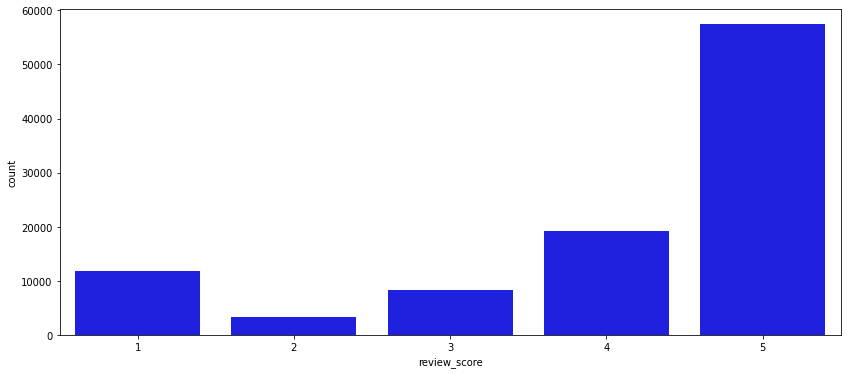

In [61]:
# Before removing Nan values
plt.figure(figsize = (14,6))
sns.countplot(review_df['review_score'], color= 'blue')

#From the plot above, close to 60,000 people gave 5 star ratings while a little above 10,000 people gave 1 star ratings

<Figure size 1008x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


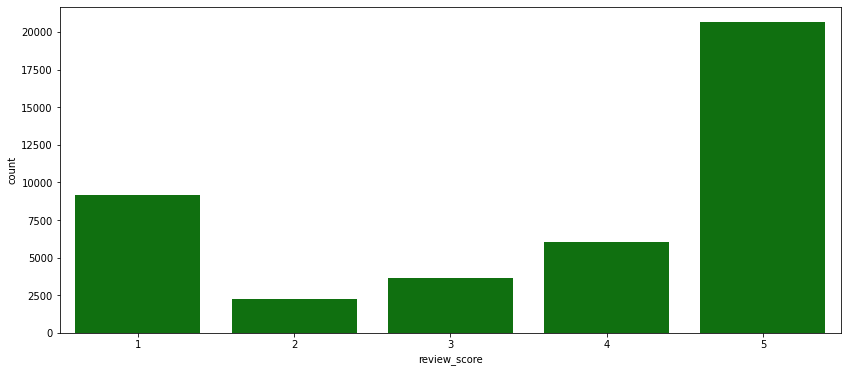

In [62]:
# After removing NaN values. Neste eu exclui as informações nulas nesse dataframe. 
plt.figure(figsize = (14,6))
sns.countplot(review_data['review_score'], color= 'Green')

No gráfico acima, após remover os valores NaN, cerca de 10.000 pessoas deram avaliações de 1 estrela, enquanto um pouco mais de 20.000 pessoas deram avaliações de 5 estrelas, o que significa que:
1. Cerca de 36% dos revisores de 5 estrelas deram comentários, enquanto 79% dos revisores de 1 estrela deram comentários, então um cliente era mais propenso a fazer comentários quando ele / ela estava insatisfeito.
2. Para entender adequadamente os clientes insatisfeitos, construiríamos um modelo de análise de sentimento que classificaria esses sentimentos. Mas antes de fazermos isso, precisamos também dar uma olhada nos títulos das avaliações.

In [63]:
# Processing the reviews titles data
comments_titles = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data_title:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    
    comments_titles.append(' '.join(filtered_result))

In [64]:
comments_titles

['recomendo',
 'super recomendo',
 'n chegou produto',
 'timo',
 'bom',
 'bom',
 'maravilhoso',
 'entrega perfeita',
 'timo',
 'mt lindo',
 'timo produto',
 'recomendo sempre',
 'recomendo',
 'n recebi produto',
 'otimo',
 'entrega atrasou',
 'boa',
 '',
 'm dio',
 'prazo entrega',
 'super produto',
 'falta produto quebra',
 'super recomendo',
 'n recebi ainda',
 'recomendo',
 'nota',
 'suspense',
 'entrega antes previsto',
 'recomendo',
 'top',
 'produto show',
 'super recoendo',
 'erraram caixa ac stica',
 'tima compra',
 'horr vel',
 'super recomendo',
 'bom',
 'otimo',
 '',
 'recomendo',
 'bom',
 'lamenet vel',
 'qualidade ruim',
 'insatisfeito',
 'mega recomendo',
 'excelente produto',
 'recomendo',
 'nao entrega produto',
 'recomendo',
 'captador presys blend',
 'produto pirata',
 'produto fraco',
 'nota',
 'tudo certo',
 'recomendo',
 'timo',
 'otimo',
 'perfeito',
 'lol pet',
 'bom',
 'excelente',
 '',
 'timo custo x benef cio',
 'bom',
 'produto entrega timos',
 'produto ok',


<Figure size 1440x864 with 0 Axes>

(-0.5, 1999.5, 999.5, -0.5)

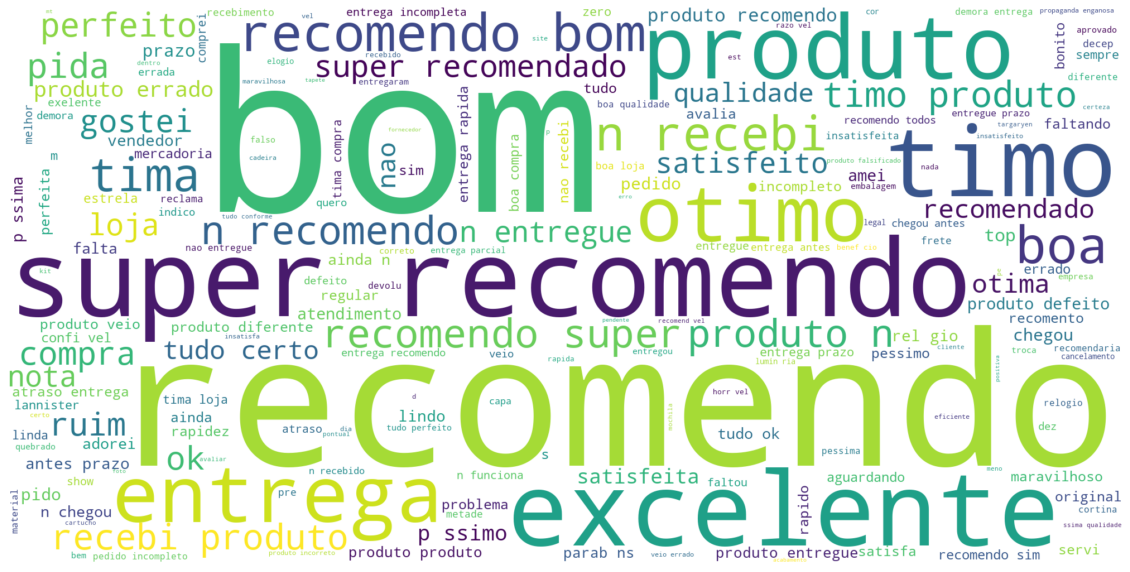

In [65]:
#Using wordcloud to visualize the comments titles
unique_string=(" ").join(comments_titles)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [66]:
# Using CountVectorizer to get the most important unigrams
co = CountVectorizer(ngram_range=(1,1))
counts = co.fit_transform(comments_titles)
important_unigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
important_unigrams_title

,0
recomendo,2085
produto,1327
bom,1321
super,901
timo,730
excelente,665
entrega,544
otimo,369
recebi,302
boa,273


In [68]:
co = CountVectorizer(ngram_range=(2,2))
counts = co.fit_transform(comments_titles)
important_bigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [69]:
important_bigrams_title

,0
super recomendo,681
recebi produto,131
super recomendado,103
timo produto,103
produto entregue,103
entrega pida,92
tudo certo,76
bom produto,76
produto errado,74
produto bom,66


In [70]:
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(comments_titles)
important_trigrams_title = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [71]:
important_trigrams_title

,0
entrega super pida,27
entrega antes prazo,15
custo benef cio,12
nao recebi produto,11
chegou antes prazo,11
produto boa qualidade,8
produto entregue prazo,8
produto nao entregue,7
produto veio defeito,7
produto veio errado,7


Uma **sacada** massa seria pedir pelo menos 3 ou 4 palavras para os clientes, visto que com tri-grama a gente já consegue se aprofundar bastante quanto a satisfação ou não do cliente bem como o problema real ocorrido.

Text(0.5, 0, 'Review Length (words)')

Text(0, 0.5, 'Frequency')

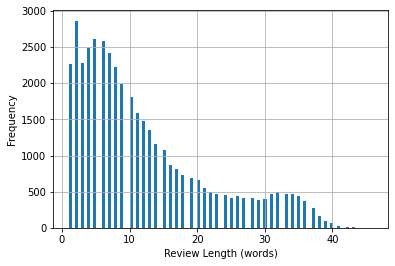

In [72]:
# Getting the number of words by splitting them by a space
words_per_review = review_data.review_comment_message.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [73]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 12.047804948147439
Skewness: 1.0577282382939468


Em seguida, leríamos nossos dados e realizaríamos algumas modificações iniciais no EDA e no conjunto de dados. O conjunto de dados de revisão tem uma quantidade significativa de valores NaN no texto e no título das revisões, portanto, teríamos certeza de eliminar esses valores ausentes e redefinir o índice.

Assim como as tarefas normais do dia-a-dia da PNL, precisamos implementar algumas etapas de pré-processamento necessárias que envolvem; transformar os dados das revisões removendo stopwords, usando o módulo de expressão regular para aceitar apenas letras, tokenizando o texto e tornando todas as palavras em minúsculas para consistência. Nesse caso, teríamos que remover palavras irrelevantes em português.

In [74]:
# Checking the percentage of the review scores. 3 and 4 are the smallest scores here. Quase 50% deram nota 5
percent_scores = 100 * review_data['review_score'].value_counts()/len(review_data)
percent_scores

5    49.447944
1    21.984049
4    14.451656
3     8.777812
2     5.338539
Name: review_score, dtype: float64


# 4° Máquina Preditiva de Análise de Sentimentos



Este seria um caso de aprendizado supervisionado, portanto, teríamos que criar uma nova coluna representando a pontuação de sentimento (1 ou 0). 1 é para palavras positivas e 0, para palavras negativas. Excluiríamos a pontuação de revisão de 3 pontos porque representa neutra e incluiríamos as pontuações de 1 e 2 como palavras negativas e as pontuações de 4 e 5 na revisão para palavras positivas.

In [75]:
# Mapping the ratings. Vou criar um campo e com um case se o score for maior que 3 é positivo (1) senão é negativo (0), ou seja 4 e 5 é positivo
review_data['Sentiment_rating'] = np.where(review_data.review_score > 3,1,0)

# Removing neutral reviews. Vou remover a galera indecisa que deu nota 3
review_data = review_data[review_data.review_score != 3]

# Printing the counts of each class
review_data['Sentiment_rating'].value_counts()

1    26680
0    11408
Name: Sentiment_rating, dtype: int64

In [76]:
# Having a look, Rows having 3 as review scores have been removed.
review_data.head()
review_data['Sentiment_rating'].shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,Sentiment_rating
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1


(38088,)

In [77]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    
    comments.append(' '.join(filtered_result))

In [78]:
co_counts = CountVectorizer(stop_words =set(stopwords.words('portuguese')),
                             ngram_range=(1,4)) # unigrams to trigrams

co_data = co_counts.fit_transform(comments)

In [79]:
co_data

<38088x420509 sparse matrix of type '<class 'numpy.int64'>'
	with 866157 stored elements in Compressed Sparse Row format>

In [80]:
# Splitting the sentiment scores column into train and test sets
X_train_co, X_test_co, y_train_co, y_test_co= train_test_split(co_data,
                                                                    review_data['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 7)

In [81]:
y_test_co.value_counts()/y_test_co.shape[0]
# 70% of sentiments are classified as positive
# 30% of sentiments are classified as negative

1    0.702678
0    0.297322
Name: Sentiment_rating, dtype: float64

In [82]:
# Defining and training the model
lr_model = LogisticRegression()
lr_model.fit(X_train_co, y_train_co)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

#5° Avaliação da Máquina

In [83]:
# Predicting the results
test_pred = lr_model.predict(X_test_co)

print("Acurácia: ", accuracy_score(y_test_co,test_pred))
print("F1 score: ", f1_score(y_test_co,test_pred))

Acurácia:  0.9226831189288527
F1 score:  0.9451633926077646


In [84]:
print("CM", confusion_matrix(y_test_co,test_pred))

CM [[1953  312]
 [ 277 5076]]


In [85]:
lr_weights = pd.DataFrame(list(zip(co_counts.get_feature_names(), # get all the n-gram feature names
                                   lr_model.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

Positive_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending = False)[:15]) # top 15 more important features for positive reviews
Positive_sentiments

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,words,weights
165942,excelente,3.281674
387705,timo,3.112662
275513,pido,2.874560
5960,adorei,2.870014
255484,otimo,2.658902
272148,perfeito,2.584949
17045,amei,2.584154
358765,satisfeito,2.421371
274464,pida,2.399248
214967,lindo,2.370964


In [86]:
Negative_Sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending = False)[-15:]) # top-15 more important features for negative reviews
Negative_Sentiments

,words,weights
273768,pessima,-1.630207
336102,recebi,-1.700524
153103,enviaram,-1.732006
146260,entregaram,-1.756037
107362,decepcionada,-1.760820
109912,demora,-1.776261
202990,insatisfeita,-1.796572
34516,atrasada,-1.815403
107283,decep,-1.816908
273840,pessimo,-1.836980


#**Resumão**

Fazemos a análise dos textos de comentários dos clientes e vimos os comentários infelizes feitos por alguns deles. Agora, cabe ao cientista / analista de dados descobrir as melhores maneiras de garantir que esses problemas sejam resolvidos.






##Inspiração trabalhos Futuros

Aqui estão algumas inspirações para os resultados possíveis deste conjunto de dados.

**PNL**:

Este conjunto de dados oferece um ambiente supremo para analisar o texto das avaliações em suas múltiplas dimensões.

**Clustering**:

Alguns clientes não escreveram um comentário. Mas por que eles estão felizes ou tão loucos?

**Previsão de vendas**:

Com as informações da data de compra, você poderá prever vendas futuras.

**Desempenho de entrega**:

Você também poderá trabalhar com o desempenho da entrega e encontrar maneiras de otimizar os tempos de entrega.

**Qualidade do produto**:

Divirta-se descobrindo as categorias de produtos que são mais propensas à insatisfação do cliente.

**Engenharia de recursos**:

Crie recursos a partir desse rico conjunto de dados ou anexe algumas informações públicas externas a ele.

**Reconhecimentos**
Obrigado a **Olist** por liberar este conjunto de dados 